# Plot hash intersections

using https://pypi.org/project/UpSetPlot/

docs at https://upsetplot.readthedocs.io/en/stable/

In [1]:
from upsetplot import generate_counts, from_memberships, plot
from matplotlib import pyplot

import glob, sourmash, itertools
import pandas as pd

In [2]:
def load_names_df(genbank_csv, override_csv):
    "load names from auto-generated CSV, override with names in override_csv"
    names_df = pd.read_csv(genbank_csv)
    accset = set(names_df.acc)

    override_df = pd.read_csv(override_csv)
    override_df = override_df[override_df.acc.isin(accset)]
    override_df.index = range(len(override_df))

    override_df['ncbi_tax_name'] = override_df['name']

    names_df.update(override_df)
    return names_df

In [3]:
def hash_intersection(sigs, subtract):
    "calculate n-way hash intersection between *sigs, then remove things in 'subtract'."
    x = set(sigs[0].minhash.hashes)
    for sig in sigs[1:]:
        x.intersection_update(sig.minhash.hashes)
    return x - subtract

def get_intersections(siglist, lengths=None, transform_name=None, min_size=1):
    """generate all 1..n combinations of signatures in siglist, then calculate hash size intersections.
    
    returns a list of counts and a list of 
    
    optional 'lengths' can be the list of ns for which you want n-wise combinations, e.g. range(2, n)
    'transform_name' can be a function that takes a signature and returns a string.
    'min_size' filters intersections - only intersections >= min_size estimated bp get kept.
    """
    combos = []
    
    if not lengths:
        lengths = [ i + 1 for i in range(len(siglist)) ]
        
    for i in lengths:
        combos.extend(itertools.combinations(siglist, i))

    sofar = set()
    intersect_hashes = []
    names = []
    counts = []
    scaled = siglist[0].minhash.scaled
    for i in reversed(combos):
        ii = hash_intersection(i, sofar)
        if len(ii) * scaled < min_size:
            continue
        intersect_hashes.append(ii)
        sofar.update(ii)

        if transform_name:
            names.append( [ transform_name(ss) for ss in i ] )
        else:
            names.append( [ str(ss) for ss in i ] )
        counts.append( len(ii)*scaled )

    return counts, names

## example - two shewanella baltica strains + A. muciniphila

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

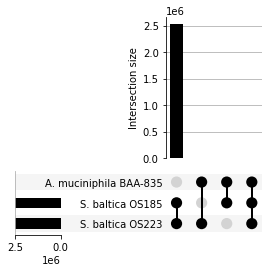

In [4]:
sigs = glob.glob('outputs/genomes/*.sig')
siglist = [ sourmash.load_one_signature(f) for f in sigs ]

names_df = load_names_df('twofoo-acc.urls.csv', 'override-names.csv')
def get_ncbi_name(sig):
    filename = sig.filename
    acc = filename.split('_')[:2]
    acc = '_'.join(acc)
    return list(names_df[names_df.acc == acc].ncbi_tax_name)[0]

counts, names = get_intersections(siglist, lengths=range(2, len(siglist)+1),
                                  transform_name=get_ncbi_name, min_size=0)

foo = from_memberships(names, counts)
plot(foo)
#pyplot.savefig('/tmp/plot.pdf')

## p8808mo11 top 9 hits - any intersections?

loaded 9 signatures


{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

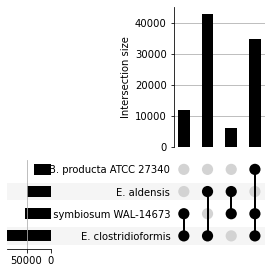

In [5]:
sigs = glob.glob('p8808mo11/*.sig')
siglist2 = [ sourmash.load_one_signature(f) for f in sigs ]
print(f'loaded {len(siglist2)} signatures')

names2_df = load_names_df('p8808mo11.acc.urls.csv', 'override-names.csv')


def get_ncbi_name2(sig):
    filename = sig.filename
    acc = filename.split('_')[:2]
    acc = '_'.join(acc)
    return list(names2_df[names2_df.acc == acc].ncbi_tax_name)[0]

counts, names = get_intersections(siglist2, lengths=range(2, len(siglist)+1),
                                  transform_name=get_ncbi_name2, min_size=5000)
foo = from_memberships(names, counts)
plot(foo)
#pyplot.savefig('/tmp/plot2.pdf')

In [ ]:
counts, names = get_intersections(siglist2, lengths=range(2, len(siglist)+1),
                                  transform_name=get_ncbi_name2, min_size=0)
foo = from_memberships(names, counts)
plot(foo)

In [ ]:
counts, names = get_intersections(siglist2,
                                  transform_name=get_ncbi_name2, min_size=10000)
foo = from_memberships(names, counts)
plot(foo)
pyplot.savefig('/tmp/plot3.pdf')